In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import psycopg2

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
import time

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'team7.cpliq65f81hf.ca-central-1.rds.amazonaws.com' ## INSERT YOUR DB ADDRESS 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'team7' ## POSTGRES USERNAME
POSTGRES_PASSWORD = 'password' ##  PASSWORD 
POSTGRES_DBNAME = 'modelingPD' ## DATABASE NAME

### Lets Crete our engine to link postgress to our jupyter file. This will allow us to access the dataset we have uploaded.

In [5]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname=POSTGRES_DBNAME))
# Create the connection
engine = create_engine(postgres_str)

In [6]:
merged_db= pd.read_sql_query('''SELECT * FROM merged;''', engine)
merged_db

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,monthly_reporting_period,current_interest_rate,loan_age,remaining_months_to_legal_maturity,adj_remaining_months_to_maturity,maturity_date,msa,current_loan_delinquency_status,modification_flag,delinquency
0,100000913397,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,...,2019-12-01,5.88,14.0,346.0,346.0,2048-10-01,40140.0,0,N,False
1,100017539727,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,...,2019-12-01,4.75,11.0,349.0,349.0,2049-01-01,26420.0,0,N,False
2,100018053040,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,...,2019-12-01,4.88,12.0,348.0,348.0,2048-12-01,0.0,0,N,False
3,100019764317,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,...,2019-10-01,4.88,9.0,351.0,0.0,2049-01-01,16980.0,X,N,True
4,100019765730,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,...,2019-12-01,4.25,8.0,352.0,352.0,2049-04-01,41860.0,0,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297447,999977469387,C,PENNYMAC CORP.,5,250000,360,2018-12-01,2019-02-01,80,80,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297448,999978067692,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",5,123000,360,2018-12-01,2019-02-01,95,95,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297449,999983023544,R,OTHER,5,280000,240,2018-12-01,2019-02-01,69,69,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297450,999984004377,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,155000,360,2019-01-01,2019-03-01,97,97,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None


### Description Of The Source Of Data

Fannie Mae provides loan performance data on a portion of its single-family mortgage loans to promote better understanding of the credit performance of Fannie Mae mortgage loans.

Link: https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html

In [7]:
# Import our input dataset
#mortgage_df = pd.read_csv('Final Project Data.csv')
mortgage_df = merged_db
mortgage_df.head()

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,monthly_reporting_period,current_interest_rate,loan_age,remaining_months_to_legal_maturity,adj_remaining_months_to_maturity,maturity_date,msa,current_loan_delinquency_status,modification_flag,delinquency
0,100000913397,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,...,2019-12-01,5.88,14.0,346.0,346.0,2048-10-01,40140.0,0,N,False
1,100017539727,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,...,2019-12-01,4.75,11.0,349.0,349.0,2049-01-01,26420.0,0,N,False
2,100018053040,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,...,2019-12-01,4.88,12.0,348.0,348.0,2048-12-01,0.0,0,N,False
3,100019764317,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,...,2019-10-01,4.88,9.0,351.0,0.0,2049-01-01,16980.0,X,N,True
4,100019765730,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,...,2019-12-01,4.25,8.0,352.0,352.0,2049-04-01,41860.0,0,N,False


In [8]:
len(mortgage_df.index)

297452

In [22]:
mortgage_df.isnull().sum()

loan_identifier                              0
origination_channel                          0
seller_name                                  0
original_interest_rate                       0
original_upb                                 0
original_loan_term                           0
origination_date                             0
first_payment_date                           0
original_ltv                                 0
original_cltv                                0
number_of_borrowers                          0
original_dir                                96
borrower_credit_score_at_origination       385
first_time_home_buyer_indicator              0
loan_purpose                                 0
property_type                                0
number_of_units                              0
occupancy_type                               0
property_state                               0
zip_code_short                               0
primary_mortgage_insurance_percent      185901
product_type 

### Drop Cloumns with low value to our model or high NULL values

In [27]:
# Drop the unwanted variables from the data
mortgage_input = mortgage_df.drop(columns = ['loan_identifier', 'maturity_date', 'monthly_reporting_period',
'current_interest_rate',
'loan_age',
'remaining_months_to_legal_maturity',
'adj_remaining_months_to_maturity',
'maturity_date',
'msa',
'primary_mortgage_insurance_percent',
'current_loan_delinquency_status',
'modification_flag' ])
mortgage_input.head()

,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,number_of_borrowers,...,first_time_home_buyer_indicator,loan_purpose,property_type,number_of_units,occupancy_type,property_state,zip_code_short,product_type,relocation_mortgage_indicator,delinquency
0,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,2,...,N,C,PU,1,P,CA,925,FRM,N,False
1,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,1,...,N,P,PU,1,P,TX,770,FRM,N,False
2,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,2,...,N,P,SF,1,S,NC,286,FRM,N,False
3,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,2,...,Y,P,SF,1,P,IL,600,FRM,N,True
4,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,1,...,Y,P,CO,1,P,CA,945,FRM,N,False


In [28]:
mortgage_input.isnull().sum()

origination_channel                          0
seller_name                                  0
original_interest_rate                       0
original_upb                                 0
original_loan_term                           0
origination_date                             0
first_payment_date                           0
original_ltv                                 0
original_cltv                                0
number_of_borrowers                          0
original_dir                                96
borrower_credit_score_at_origination       385
first_time_home_buyer_indicator              0
loan_purpose                                 0
property_type                                0
number_of_units                              0
occupancy_type                               0
property_state                               0
zip_code_short                               0
product_type                                 0
relocation_mortgage_indicator                0
delinquency  

### Remove all Nan Values

In [29]:
# Drop NA rows
mortgage_input = mortgage_input.dropna()
len(mortgage_input.index)
mortgage_input.head(10)

,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,number_of_borrowers,...,first_time_home_buyer_indicator,loan_purpose,property_type,number_of_units,occupancy_type,property_state,zip_code_short,product_type,relocation_mortgage_indicator,delinquency
0,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,2,...,N,C,PU,1,P,CA,925,FRM,N,False
1,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,1,...,N,P,PU,1,P,TX,770,FRM,N,False
2,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,2,...,N,P,SF,1,S,NC,286,FRM,N,False
3,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,2,...,Y,P,SF,1,P,IL,600,FRM,N,True
4,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,1,...,Y,P,CO,1,P,CA,945,FRM,N,False
5,C,"WELLS FARGO BANK, N.A.",5,453000,360,2018-12-01,2019-02-01,69,69,2,...,N,P,PU,1,P,FL,337,FRM,N,False
6,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,264000,360,2018-10-01,2018-12-01,95,95,2,...,N,P,PU,1,P,TX,773,FRM,Y,False
7,R,"MOVEMENT MORTGAGE, LLC",5,426000,360,2019-01-01,2019-03-01,80,80,1,...,N,P,CO,1,P,TX,752,FRM,N,False
8,R,OTHER,5,174000,360,2018-12-01,2019-02-01,97,97,2,...,Y,P,SF,1,P,IN,479,FRM,N,False
9,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",5,204000,360,2019-01-01,2019-03-01,95,95,2,...,Y,P,PU,1,P,UT,844,FRM,N,False


### Now that we have cleaned our data set, lets see what input we have for our ML model

In [30]:
# Generate our categorical variable list
mortgage_cat = mortgage_input.dtypes[mortgage_input.dtypes == "object"].index.tolist()
mortgage_cat

['origination_channel',
 'seller_name',
 'origination_date',
 'first_payment_date',
 'first_time_home_buyer_indicator',
 'loan_purpose',
 'property_type',
 'occupancy_type',
 'property_state',
 'product_type',
 'relocation_mortgage_indicator',
 'delinquency']

### Since we are focusing on potential forclosure risk, we will be looking in to all the states, all the loan sellers, type of property and other indicators

In [31]:
# Check the number of unique values in each column
mortgage_input[mortgage_cat].nunique()

origination_channel                 3
seller_name                        17
origination_date                   26
first_payment_date                 26
first_time_home_buyer_indicator     2
loan_purpose                        3
property_type                       5
occupancy_type                      3
property_state                     54
product_type                        1
relocation_mortgage_indicator       2
delinquency                         2
dtype: int64

### we will now use one hot encoder to turn object/string data into interbased data to set up our ML

In [32]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(mortgage_input[mortgage_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(mortgage_cat)
encode_df.head()

,origination_channel_B,origination_channel_C,origination_channel_R,"seller_name_AMERIHOME MORTGAGE COMPANY, LLC",seller_name_DITECH FINANCIAL LLC,"seller_name_EAGLE HOME MORTGAGE, LLC",seller_name_FAIRWAY INDEPENDENT MORTGAGE CORPORATION,"seller_name_FLAGSTAR BANK, FSB",seller_name_FREEDOM MORTGAGE CORP.,"seller_name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",...,property_state_VT,property_state_WA,property_state_WI,property_state_WV,property_state_WY,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### We will now merge the one hot encoder data to our original dataset

In [33]:
# Merge one-hot encoded features and drop the originals
mortgage_merged = mortgage_input.merge(encode_df,left_index=True, right_index=True)
mortgage_merged = mortgage_merged.drop(mortgage_cat,1)
mortgage_merged.head()

,original_interest_rate,original_upb,original_loan_term,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,number_of_units,zip_code_short,...,property_state_VT,property_state_WA,property_state_WI,property_state_WV,property_state_WY,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
0,6,324000,360,80,80,2,49.0,692.0,1,925,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,5,307000,360,90,90,1,44.0,722.0,1,770,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,5,256000,360,90,90,2,41.0,728.0,1,286,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,5,248000,360,90,90,2,40.0,730.0,1,600,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,4,490000,360,67,67,1,35.0,727.0,1,945,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [16]:
mortgage_merged["Foreclosure"] = foreclosure_rng
mortgage_merged

,original_interest_rate,original_upb,original_loan_term,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,number_of_units,zip_code_short,...,current_loan_deliquency_status_3,current_loan_deliquency_status_4,current_loan_deliquency_status_5,current_loan_deliquency_status_6,current_loan_deliquency_status_7,current_loan_deliquency_status_8,current_loan_deliquency_status_9,current_loan_deliquency_status_X,modification_flag_N,Foreclosure
1,5,307000,360,90,90,1,44.0,722.0,1,770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,5,256000,360,90,90,2,41.0,728.0,1,286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,5,248000,360,90,90,2,40.0,730.0,1,600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
6,5,264000,360,95,95,2,45.0,710.0,1,773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
8,5,174000,360,97,97,2,37.0,747.0,1,479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37552,6,103000,360,97,97,1,20.0,661.0,1,450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
37554,5,147000,360,95,95,2,45.0,731.0,1,503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
37556,6,165000,360,97,102,1,23.0,679.0,1,604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
37557,5,341000,360,97,97,1,45.0,748.0,1,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [17]:
# Split our preprocessed data into our features and target arrays
y = mortgage_merged["Foreclosure"].values
X = mortgage_merged.drop(["Foreclosure"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
#% For deep forest neural network use this cell and all cells with % sign

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.719


In [22]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.7193732193732194


### Model the Data

We initially were using higher number of nodes which was giving us a high LOSS value at over 1.3
1817/1817 - 0s - loss: 1.3006 - acc: 0.6258
Loss: 1.3005778135410953, Accuracy: 0.6257567405700684

So we reduce the number of nodes to better scale with the data.
hidden_nodes_layer1 = 24
hidden_nodes_layer2 = 8
to
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 3
and saw  significant improvement on accuracy and loss. ill work through it this week, and will see if i can get a piepline going.

1817/1817 - 0s - loss: 0.6634 - acc: 0.6868
Loss: 0.663360848850645, Accuracy: 0.6868464350700378

In [35]:
#% For deep forest neural network use this cell and all cells with % sign

# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

#add multiple hidden layers
#first i created a list of int to be used as nodes
units = [ 32, 21, 15, 6, 11, 17, 5]

#then using a for loop i created multiple layers for our machine learnign model
for i in range( 7 ):
    nn.add( tf.keras.layers.Dense( units[i] , activation= activ_func ) )

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
10528/10528 [==============================] - 2s 154us/sample - loss: 0.5933 - acc: 0.7349
Epoch 2/50
10528/10528 [==============================] - 1s 98us/sample - loss: 0.5736 - acc: 0.7371
Epoch 3/50
10528/10528 [==============================] - 1s 98us/sample - loss: 0.5684 - acc: 0.7371
Epoch 4/50
10528/10528 [==============================] - 1s 100us/sample - loss: 0.5636 - acc: 0.7370
Epoch 5/50
10528/10528 [==============================] - 1s 101us/sample - loss: 0.5557 - acc: 0.7370
Epoch 6/50
10528/10528 [==============================] - 1s 97us/sample - loss: 0.5487 - acc: 0.7370
Epoch 7/50
10528/10528 [==============================] - 1s 95us/sample - loss: 0.5398 - acc: 0.7434
Epoch 8/50
10528/10528 [==============================] - 1s 94us/sample - loss: 0.5294 - acc: 0.7524
Epoch 9/50
10528/10528 [==============================] - 1s 91us/sample - loss: 0.5189 - acc: 0.7593
Epoch 10/50
10528/10528 [==============================] - 1s 94us/sample - los

In [24]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/cp.{acc:.4f}-{epoch:02d}.hdf5"

### Lets fit the model and evaluate the results

In [25]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    verbose=1,
    #save_best_only=True,
    save_weights_only=False,
    save_freq='epoch')

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=60,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/60
10304/10528 [============================>.] - ETA: 0s - loss: 0.5880 - acc: 0.7377
Epoch 00001: saving model to checkpoints/cp.0.7371-01.hdf5
10528/10528 [==============================] - 3s 241us/sample - loss: 0.5885 - acc: 0.7371
Epoch 2/60
10336/10528 [============================>.] - ETA: 0s - loss: 0.5712 - acc: 0.7380
Epoch 00002: saving model to checkpoints/cp.0.7371-02.hdf5
10528/10528 [==============================] - 1s 123us/sample - loss: 0.5721 - acc: 0.7371
Epoch 3/60
10336/10528 [============================>.] - ETA: 0s - loss: 0.5667 - acc: 0.7359
Epoch 00003: saving model to checkpoints/cp.0.7371-03.hdf5
10528/10528 [==============================] - 1s 122us/sample - loss: 0.5658 - acc: 0.7371
Epoch 4/60
10432/10528 [============================>.] - ETA: 0s - loss: 0.5575 - acc: 0.7369
Epoch 00004: saving model to checkpoints/cp.0.7371-04.hdf5
10528/10528 [=

Epoch 33/60
10112/10528 [===========================>..] - ETA: 0s - loss: 0.2694 - acc: 0.8979
Epoch 00033: saving model to checkpoints/cp.0.8968-33.hdf5
10528/10528 [==============================] - 1s 119us/sample - loss: 0.2706 - acc: 0.8968
Epoch 34/60
10368/10528 [============================>.] - ETA: 0s - loss: 0.2624 - acc: 0.8968
Epoch 00034: saving model to checkpoints/cp.0.8973-34.hdf5
10528/10528 [==============================] - 1s 122us/sample - loss: 0.2619 - acc: 0.8973
Epoch 35/60
10176/10528 [===========================>..] - ETA: 0s - loss: 0.2545 - acc: 0.9016
Epoch 00035: saving model to checkpoints/cp.0.9004-35.hdf5
10528/10528 [==============================] - 1s 119us/sample - loss: 0.2567 - acc: 0.9004
Epoch 36/60
10144/10528 [===========================>..] - ETA: 0s - loss: 0.2511 - acc: 0.9032
Epoch 00036: saving model to checkpoints/cp.0.9031-36.hdf5
10528/10528 [==============================] - 1s 119us/sample - loss: 0.2506 - acc: 0.9031
Epoch 37/60


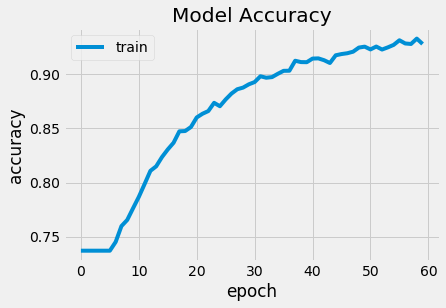

In [30]:
from matplotlib import pyplot as plt
plt.plot(fit_model.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

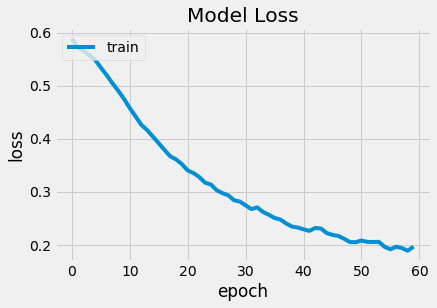

In [31]:
plt.plot(fit_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [28]:
X_train_scaled

array([[ 1.89619223, -0.40967756,  0.09211852, ..., -0.016883  ,
        -0.44772324,  0.        ],
       [ 1.89619223, -1.33639843,  0.09211852, ..., -0.016883  ,
        -0.44772324,  0.        ],
       [-0.21899232,  0.39067229,  0.09211852, ..., -0.016883  ,
        -0.44772324,  0.        ],
       ...,
       [-0.21899232,  0.09580656,  0.09211852, ..., -0.016883  ,
        -0.44772324,  0.        ],
       [-0.21899232,  0.66868855,  0.09211852, ..., -0.016883  ,
        -0.44772324,  0.        ],
       [-2.33417687,  1.46903839,  0.09211852, ..., -0.016883  ,
        -0.44772324,  0.        ]])